In [ ]:
import cv2
import os
import pathlib
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Dense, Reshape, LayerNormalization, LeakyReLU
from keras import layers, models
import tensorflow as tf
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score

In [ ]:
class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape
    def returListImages(self,):
        self.images = []
        for label in self.labels:
            self.images.append(list(pathlib.Path(os.path.join(self.datasetpath,
                                                              label)).glob('*.*')))
    def readImages(self,):
        self.returListImages()
        self.finalImages = []
        labels = []
        for label in range(len(self.labels)):
            for img in self.images[label]:
                img = cv2.imread(str(img))
                img = cv2.resize(img , self.image_shape)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img  = img/255
                self.finalImages.append(img)
                labels.append(label)
        images = np.array(self.finalImages)
        labels = np.array(labels)
        return images, labels

In [ ]:
readDatasetObject = ReadDataset('./chest_xray/train',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
images, labels = readDatasetObject.readImages()

In [ ]:
images.shape, labels.shape

((5216, 64, 64, 3), (5216,))

Sample images included in the dataset for each class

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


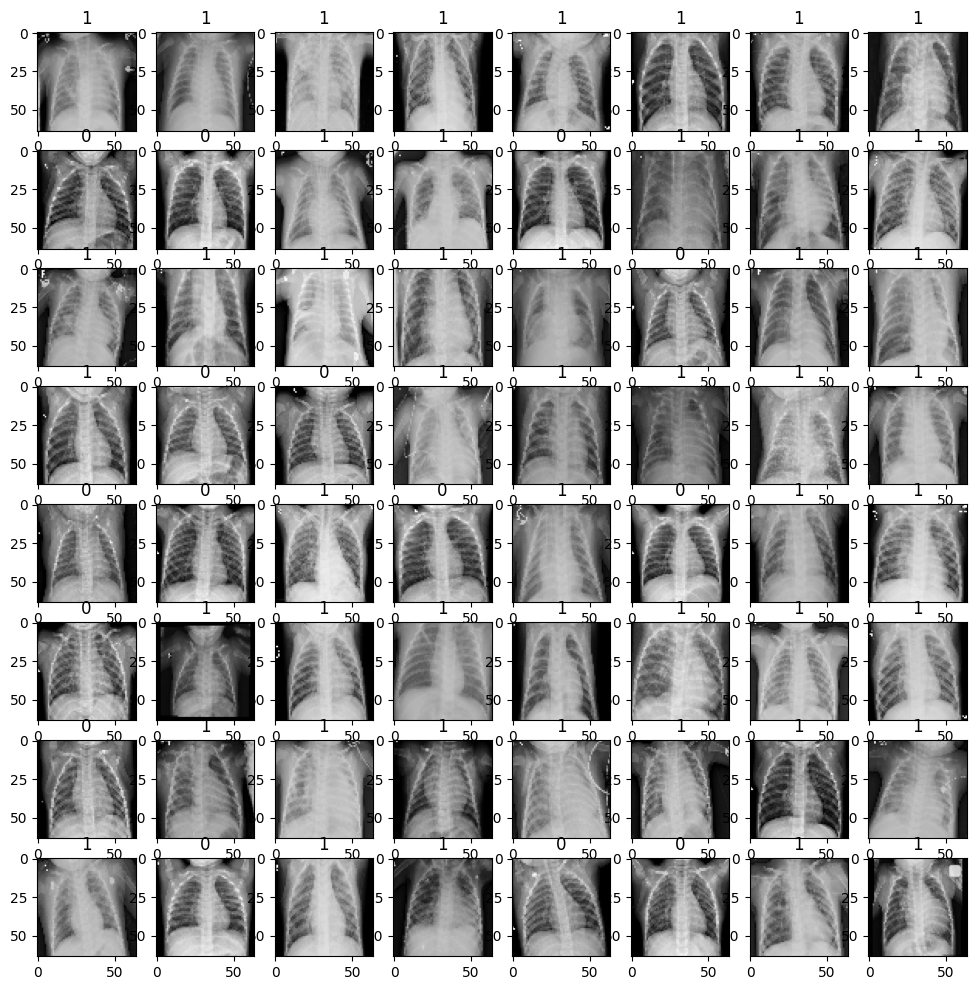

In [ ]:
plt.figure(figsize = (12, 12))
indexs = np.random.randint(0, len(labels), size = (64, ))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(images[indexs[i]])
    plt.title(labels[indexs[i]])
plt.legend()

In [ ]:
class Acgan:
    def __init__(self, eta, batch_size, epochs, weight_decay, latent_space,
                 image_shape, kernel_size):
        self.eta = eta
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.latent_space = latent_space
        self.image_shape = image_shape
        self.kernel_size = kernel_size
    def data(self, images, labels):
        ytrain = tf.keras.utils.to_categorical(labels)
        self.images = images
        self.labels = ytrain
    def samples(self, G, noize, labels):
        images = G.predict([noize, labels])
        ys = np.argmax(labels, axis = 1)
        plt.figure(figsize = (12, 4))
        for i in range(16):
            plt.subplot(2, 8, (i + 1))
            plt.imshow(images[i], cmap = 'gray')
            plt.title(ys[i])
        plt.show()
    def generator(self, inputs, labels):
        filters = [256, 128, 64, 32]
        padding = 'same'
        x = inputs
        y = labels
        x = layers.concatenate([x, y])
        x = layers.Dense(1024, )(x)
        x = layers.Dense(8*8*filters[0],
                         kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        x = layers.Reshape((8, 8, filters[0]))(x)
        for filter in filters:
            if filter >= 64:
                strides = 2
            else:
                strides = 1
            x = LayerNormalization()(x)
            x = layers.Activation('relu')(x)
            x = Conv2DTranspose(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides)(x)
        x = Conv2DTranspose(3, kernel_size = self.kernel_size, padding = padding)(x)
        x = layers.Activation('sigmoid')(x)
        self.generatorModel = models.Model(inputs = [inputs, labels],
                                           outputs = x,
                                           name = 'generator')
    def discriminator(self, inputs):
        x = inputs
        filters = [32, 64, 128, 256]
        padding = 'same'
        for filter in filters:
            if filter < 256:
                strides = 2
            else:
                strides = 1
            x = Conv2D(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides,
                      kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
            x = LeakyReLU(alpha = 0.2)(x)
        x = layers.Flatten()(x)
        outputs = Dense(1, )(x)
        labelsOutput = Dense(256,
                             kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        labelsOutput = Dropout(0.3)(labelsOutput)
        labelsOutput = Dense(2,)(labelsOutput)
        labelsOutput = layers.Activation('softmax')(labelsOutput)
        self.discriminatorModel = models.Model(inputs = inputs,
                                               outputs = [outputs, labelsOutput],
                                               name = 'discriminator')
    def build(self,):
        generatorInput = layers.Input(shape = (self.latent_space))
        discriminatorInput = layers.Input(shape = (self.image_shape))
        labelsInput = layers.Input(shape = (2, ))
        self.generator(generatorInput, labelsInput)
        self.discriminator(discriminatorInput)
        G = self.generatorModel
        D = self.discriminatorModel
        D.compile(loss = ['mse', 'binary_crossentropy'],
                 optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta,
                                                        weight_decay = self.weight_decay))
        D.summary()
        G.summary()
        D.trainable = False
        GAN = models.Model(inputs = [generatorInput, labelsInput],
                           outputs = D(G([generatorInput, labelsInput])))
        GAN.compile(loss = ['mse', 'binary_crossentropy'],
                   optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta*0.5,
                                                          weight_decay = self.weight_decay*0.5))
        GAN.summary()
        return G, D, GAN
    def trainAlgorithm(self, G, D, GAN):
        for epoch in range(self.epochs):
            indexs = np.random.randint(0, len(self.images), size = (self.batch_size, ))
            realImages = self.images[indexs]
            realLabels = self.labels[indexs]
            realTag = tf.ones(shape = (self.batch_size, ))
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            fakeLabels = tf.keras.utils.to_categorical(np.random.choice(range(2), size = (self.batch_size)),
                                                      num_classes = 2)
            fakeImages = tf.squeeze(G.predict([noize, fakeLabels], verbose = 0))
            fakeTag = tf.zeros(shape = (self.batch_size, ))
            allImages = np.vstack([realImages, fakeImages])
            allLabels = np.vstack([realLabels, fakeLabels])
            allTags = np.hstack([realTag, fakeTag])
            _, dlossTag, dlossLabels = D.train_on_batch(allImages, [allTags, allLabels])
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            _, glossTag, glossLabels = GAN.train_on_batch([noize, fakeLabels], [realTag, fakeLabels])
            if epoch % 5000 == 0:
                print('Epoch: {}'.format(epoch))
                print('discriminator loss: [tag: {}, labels: {}], generator loss: [tag: {}, labels: {}]'.format(dlossTag,
                                                                                                                dlossLabels,
                                                                                                                glossTag,
                                                                                                                glossLabels))
                self.samples(G, noize, fakeLabels)

In [ ]:
acgan = Acgan(eta = 0.0001, batch_size = 32, epochs = 10000, weight_decay = 6e-9,
              latent_space = 100, image_shape = (64, 64, 3), kernel_size = 5)

In [ ]:
acgan.data(images, labels)

In [ ]:
G, D, GAN = acgan.build()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   2432        ['input_2[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   51264       ['leaky_re_lu[0][0]']            
                                                                                      

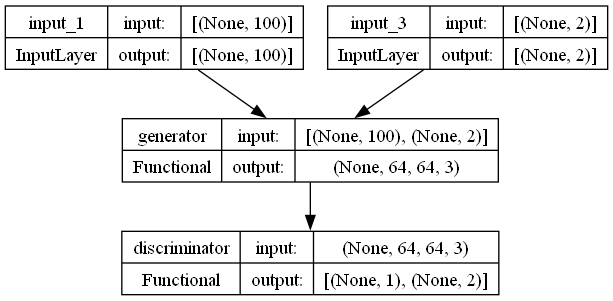

In [ ]:
tf.keras.utils.plot_model(GAN, show_shapes=True)

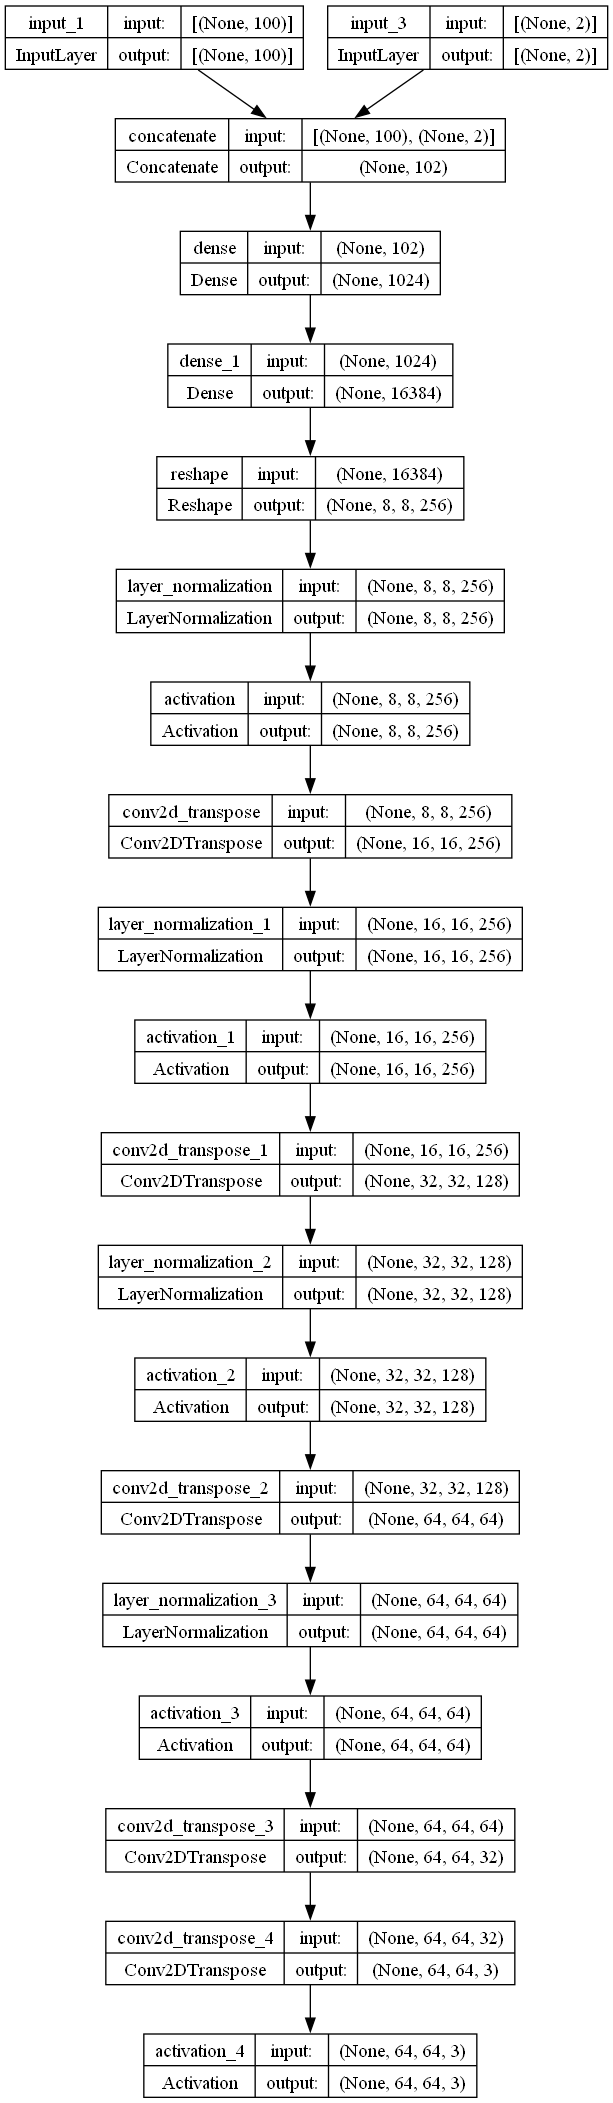

In [ ]:
tf.keras.utils.plot_model(G, show_shapes = True)

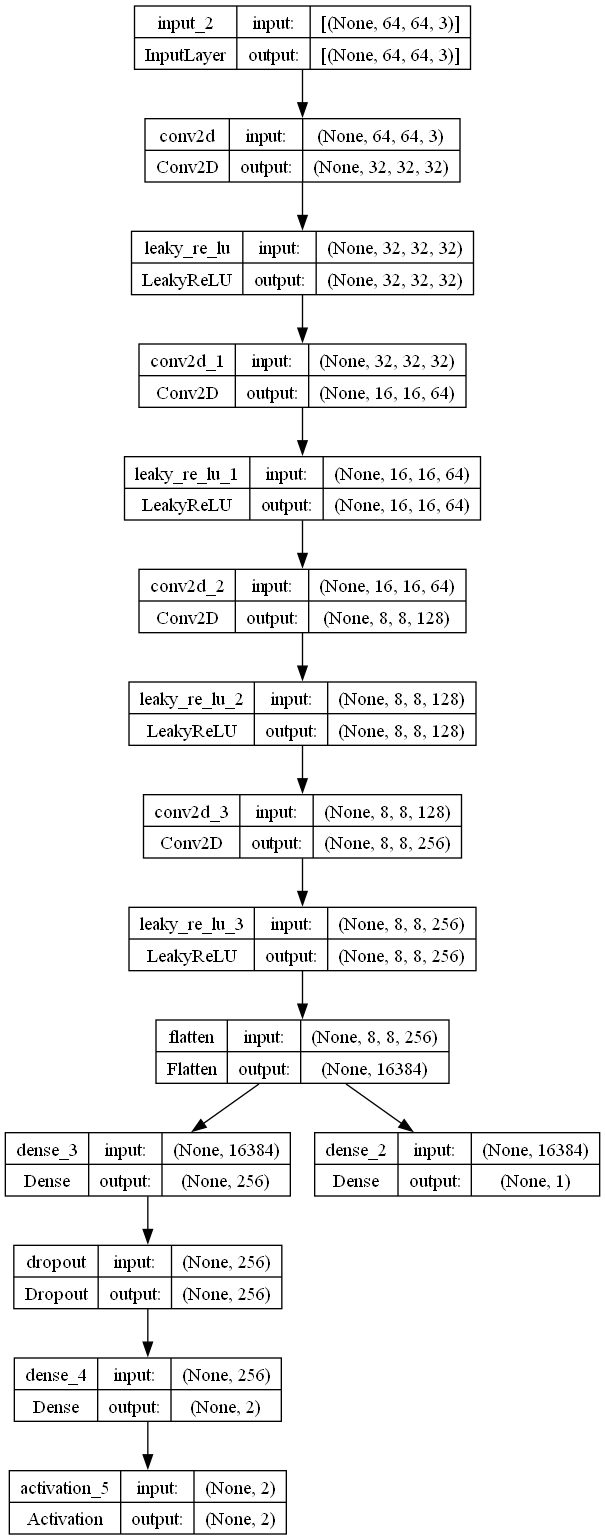

In [ ]:
tf.keras.utils.plot_model(D, show_shapes = True)

Epoch: 0
discriminator loss: [tag: 0.4831520915031433, labels: 0.6966838836669922], generator loss: [tag: 0.09918354451656342, labels: 0.6991938948631287]
1/1 [==============================] - 0s 311ms/step


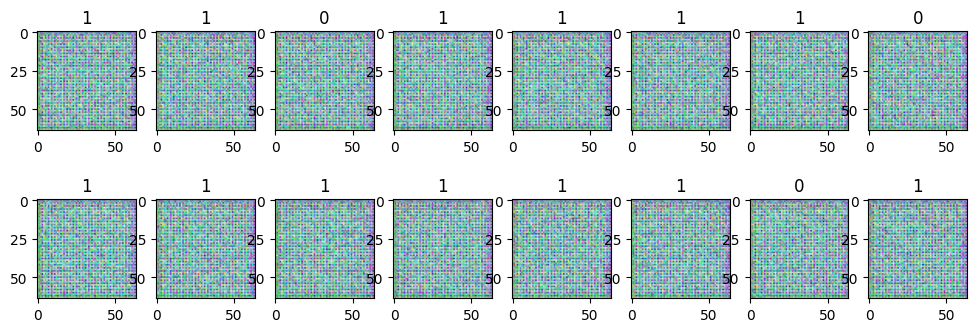

Epoch: 5000
discriminator loss: [tag: 0.24129480123519897, labels: 0.003692172933369875], generator loss: [tag: 0.3180003762245178, labels: 0.0014789600390940905]
1/1 [==============================] - 1s 717ms/step


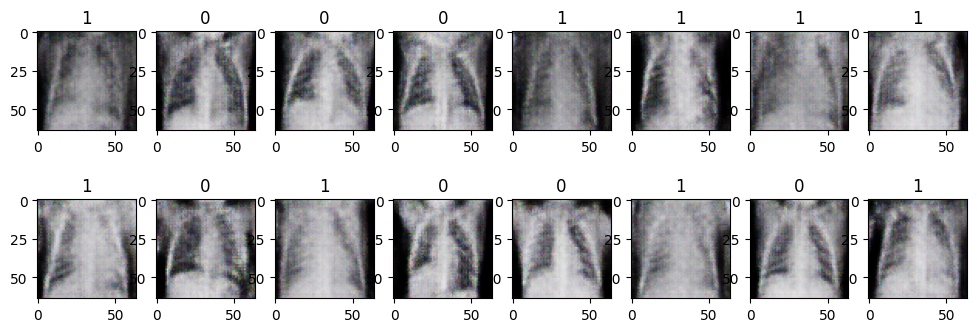

In [ ]:
acgan.trainAlgorithm(G, D, GAN)

In [ ]:
G.save('./chest_xray/working/generator.h5')

In [ ]:
G = tf.keras.models.load_model('./chest_xray/working/generator.h5')

In [ ]:
datasetGenerationSize = 30000
noize = tf.random.uniform(shape = (datasetGenerationSize, 100), minval = -1, maxval = 1)
newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size = (datasetGenerationSize, )), num_classes = 2)

In [ ]:
noize.shape, newlabels.shape

(TensorShape([30000, 100]), (30000, 2))

In [ ]:
np.unique(np.argmax(newlabels, axis = 1), return_counts = True)

(array([0, 1], dtype=int64), array([15084, 14916], dtype=int64))

In [ ]:
imagesGeneration = G.predict([noize, newlabels])
imagesGeneration.shape

938/938 [==============================] - 1452s 2s/step


(30000, 64, 64, 3)

- Samples generated by the generator for each case (healthy person, person with pneumonia).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


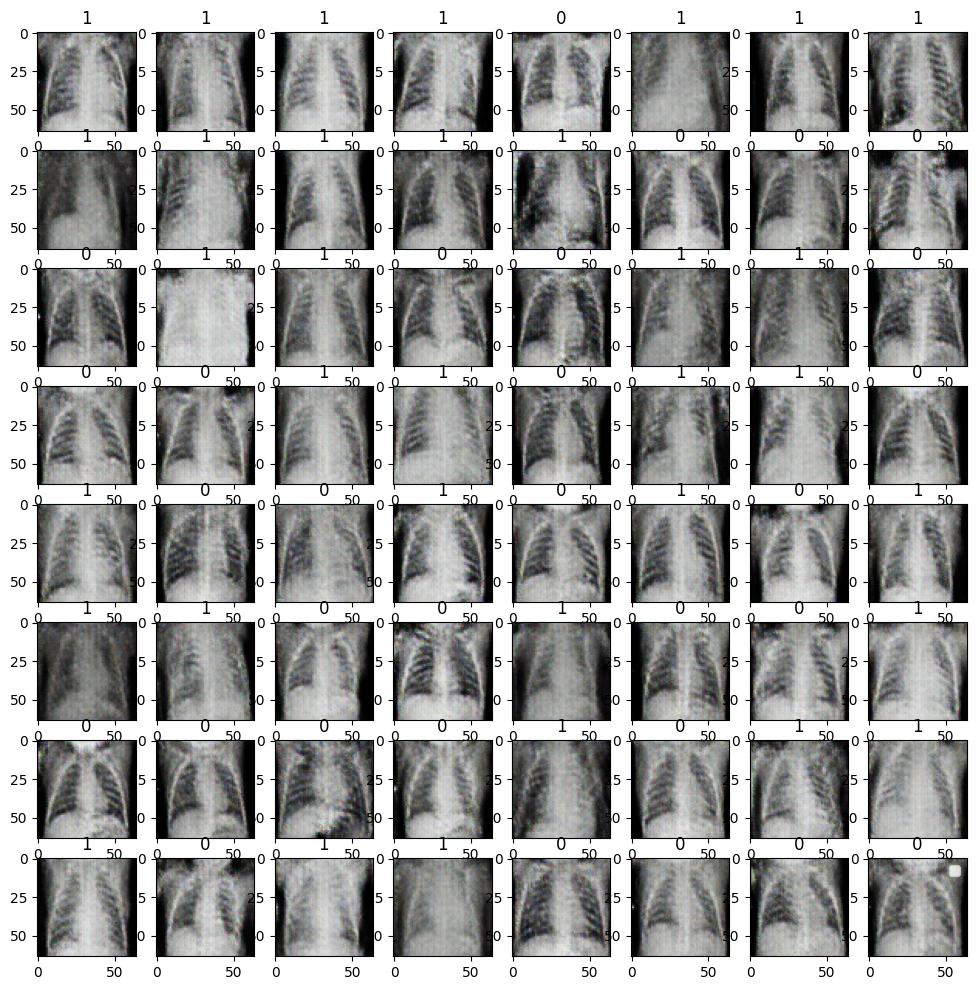

In [ ]:
plt.figure(figsize = (12, 12))
t = np.argmax(newlabels, axis = 1)
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(imagesGeneration[i])
    plt.title(t[i])
plt.legend()

In [ ]:
basemodel = tf.keras.applications.VGG16(weights = None, input_shape = (64, 64, 3),
                                        pooling = 'max', include_top = False)
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)
m = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001))
m.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

- Training the neural network to classify the images generated by the generator.

In [ ]:
history = m.fit(imagesGeneration, np.argmax(newlabels, axis = 1),
                epochs = 5, batch_size = 64,
                validation_split = 0.2,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss', mode = 'min',
                                                              restore_best_weights = True)])

Epoch 1/5
375/375 [==============================] - 6319s 17s/step - loss: 0.0352 - val_loss: 0.0202
Epoch 2/5
375/375 [==============================] - 6279s 17s/step - loss: 0.0332 - val_loss: 0.0160
Epoch 3/5
375/375 [==============================] - 6380s 17s/step - loss: 0.0316 - val_loss: 0.0149
Epoch 4/5
375/375 [==============================] - 6346s 17s/step - loss: 0.0284 - val_loss: 0.0127
Epoch 5/5
375/375 [==============================] - 6351s 17s/step - loss: 0.0257 - val_loss: 0.0124


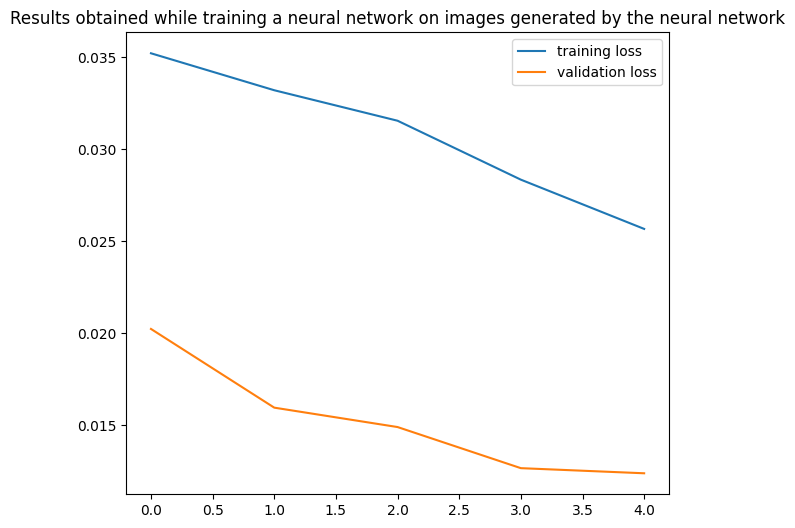

In [ ]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

- Now, after training on the images generated by the generator, we will test the neural network on the basic images included in the dataset.

In [ ]:
m.evaluate(images, labels)

163/163 [==============================] - 406s 2s/step - loss: 0.1909


0.19091378152370453

In [ ]:
y_pred = tf.squeeze(m.predict(images))
y_pred.shape

163/163 [==============================] - 405s 2s/step


TensorShape([5216])

In [ ]:
y_pred = y_pred >= 0.5
y_pred = np.array(y_pred, dtype = 'int32')
y_pred

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
accuracy_score(y_pred, labels)*100

92.8680981595092

In [ ]:
print(classification_report(y_pred, labels))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88      1691
           1       0.91      1.00      0.95      3525

    accuracy                           0.93      5216
   macro avg       0.95      0.89      0.91      5216
weighted avg       0.93      0.93      0.93      5216



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred, labels)
cm

array([[1330,  361],
       [  11, 3514]], dtype=int64)

In [ ]:
import pandas as pd
cmObject = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
cmObject.head()

,NORMAL,PNEUMONIA
NORMAL,1330,361
PNEUMONIA,11,3514


In [ ]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_pred, labels)*100,
                                                                   recall_score(y_pred, labels)*100,
                                                                   precision_score(y_pred, labels)*100))

f1_score: 94.97297297297297, recall_score: 99.68794326241135, precision_score: 90.68387096774192


<AxesSubplot: >

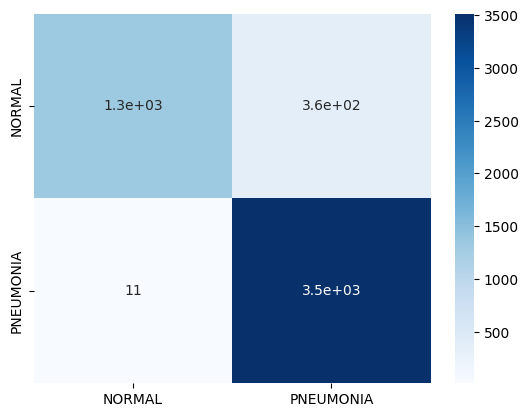

In [ ]:
sns.heatmap(cmObject, annot = True, cmap="Blues")